In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#This is necesery to latter load tcn module ( google colab thing )
from importlib.machinery import SourceFileLoader
tcnmodule = SourceFileLoader('tcn', '/content/drive/My Drive/Fax/Master Theses/keras-tcn-master/tcn/tcn.py').load_module()

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding
from sklearn import preprocessing

import os
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers.core import Activation
from tensorflow.keras.models import Sequential,load_model, model_from_json

from tcn import TCN

In [0]:
# define path to save data
model_path = '/content/drive/My Drive/Fax/Master Theses/output-tcn2/mode.h5'
output_path = '/content/drive/My Drive/Fax/Master Theses/output-tcn2'

data_path = '/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/'

  

In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(data_path+'test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(data_path+'RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


In [0]:
######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)


   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [0]:
# pick a large window size of 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# TODO for debug 
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

162
(17631, 30, 25)


(17631, 1)

In [0]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [0]:
##output tcn
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]


def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

i = Input(shape=(sequence_length, nb_features))
m = TCN()(i)
m = Dense(1, activation='linear')(m)

#m = TCN(nb_filters=32,return_sequences=True)(m)
#m = TCN(nb_filters=16,return_sequences=False)(m)
#m = Dense(1, activation='relu')(m)
model = Model(inputs=[i], outputs=[m])
'''
i = Input(shape=(sequence_length,nb_features))
x = TCN(nb_filters=64,
        kernel_size=6,
        dilations=[1,1,1, 1, 1, 1, 1, ])(i)
x = Dense(1, activation='linear')(x)
model = Model(inputs=[i], outputs=[x])
'''

model.summary()

model.compile('adam', 'mae')
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 25)]          0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                121536    
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 121,601
Trainable params: 121,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
##output tcn2
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]


def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

i = Input(shape=(sequence_length, nb_features))
#m = TCN()(i)
#m = Dense(1, activation='linear')(m)

m = TCN(nb_filters=32,return_sequences=True)(i)
m = TCN(nb_filters=16,return_sequences=False)(m)
m = Dense(1, activation='linear')(m)
model = Model(inputs=[i], outputs=[m])
'''
i = Input(shape=(sequence_length,nb_features))
x = TCN(nb_filters=64,
        kernel_size=6,
        dilations=[1,1,1, 1, 1, 1, 1, ])(i)
x = Dense(1, activation='linear')(x)
model = Model(inputs=[i], outputs=[x])
'''

model.summary()

model.compile('adam', 'mae')
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 25)]          0         
_________________________________________________________________
tcn_4 (TCN)                  (None, 50, 32)            31072     
_________________________________________________________________
tcn_5 (TCN)                  (None, 16)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 39,313
Trainable params: 39,313
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

Train on 14849 samples, validate on 782 samples
Epoch 1/100
14849/14849 - 27s - loss: 2970.6680 - mean_absolute_error: 39.3417 - r2_keras: 0.0625 - val_loss: 1754.5605 - val_mean_absolute_error: 32.3570 - val_r2_keras: 0.4428
Epoch 2/100
14849/14849 - 22s - loss: 1643.3534 - mean_absolute_error: 29.7159 - r2_keras: 0.4966 - val_loss: 1677.9411 - val_mean_absolute_error: 27.2617 - val_r2_keras: 0.4690
Epoch 3/100
14849/14849 - 22s - loss: 1276.3854 - mean_absolute_error: 25.5070 - r2_keras: 0.6057 - val_loss: 1563.7764 - val_mean_absolute_error: 34.3781 - val_r2_keras: 0.4954
Epoch 4/100
14849/14849 - 22s - loss: 1101.2502 - mean_absolute_error: 23.2325 - r2_keras: 0.6609 - val_loss: 1529.4835 - val_mean_absolute_error: 33.4320 - val_r2_keras: 0.5142
Epoch 5/100
14849/14849 - 22s - loss: 1001.8976 - mean_absolute_error: 22.3569 - r2_keras: 0.6945 - val_loss: 913.4017 - val_mean_absolute_error: 18.2324 - val_r2_keras: 0.7140
Epoch 6/100
14849/14849 - 22s - loss: 841.6072 - mean_absolute_

dict_keys(['loss', 'mean_absolute_error', 'r2_keras', 'val_loss', 'val_mean_absolute_error', 'val_r2_keras'])


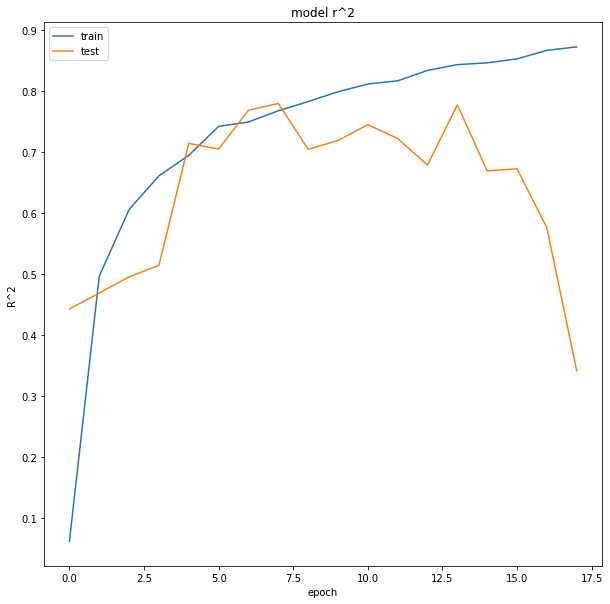

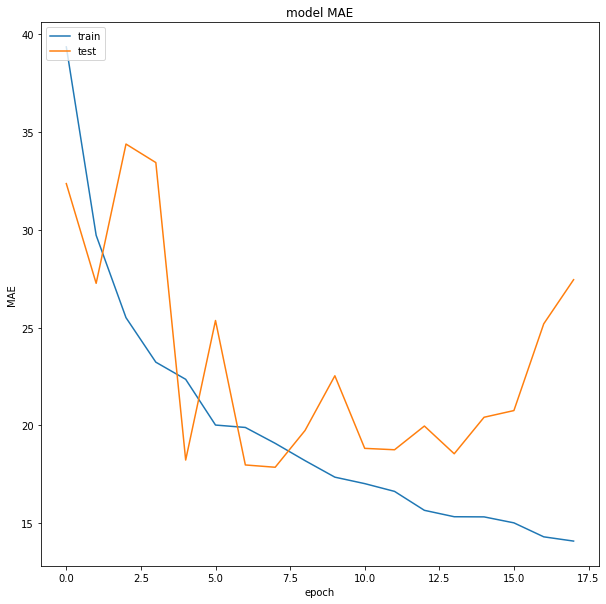

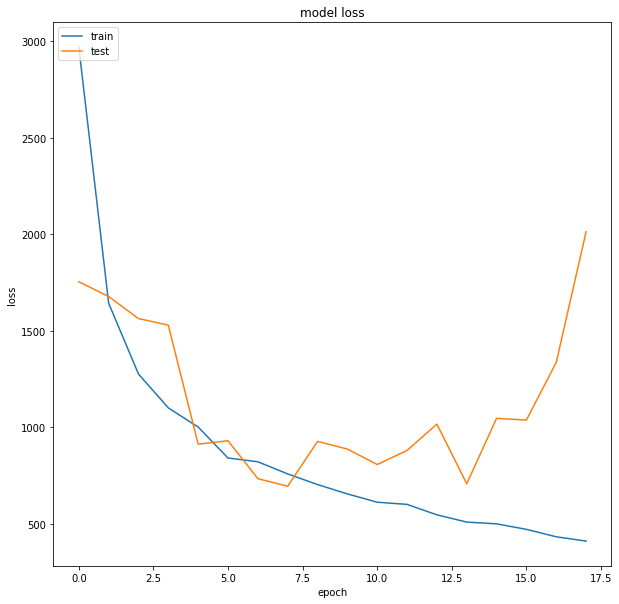

15631/15631 [==============================] - 8s 506us/sample - loss: 550.8585 - mean_absolute_error: 15.8672 - r2_keras: 0.6898

MAE: 15.867226600646973

R^2: 0.689841091632843
15631/15631 [==============================] - 8s 541us/sample


In [0]:

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_regression_loss.png")

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv(output_path+'/submit_train.csv', index = None)


seq_array_test_last
(93, 50, 25)
(93, 1)
93/93 - 1s - loss: 390.2394 - mean_absolute_error: 13.8707 - r2_keras: 0.7673

MAE: 13.870657920837402

R^2: 0.7672967910766602


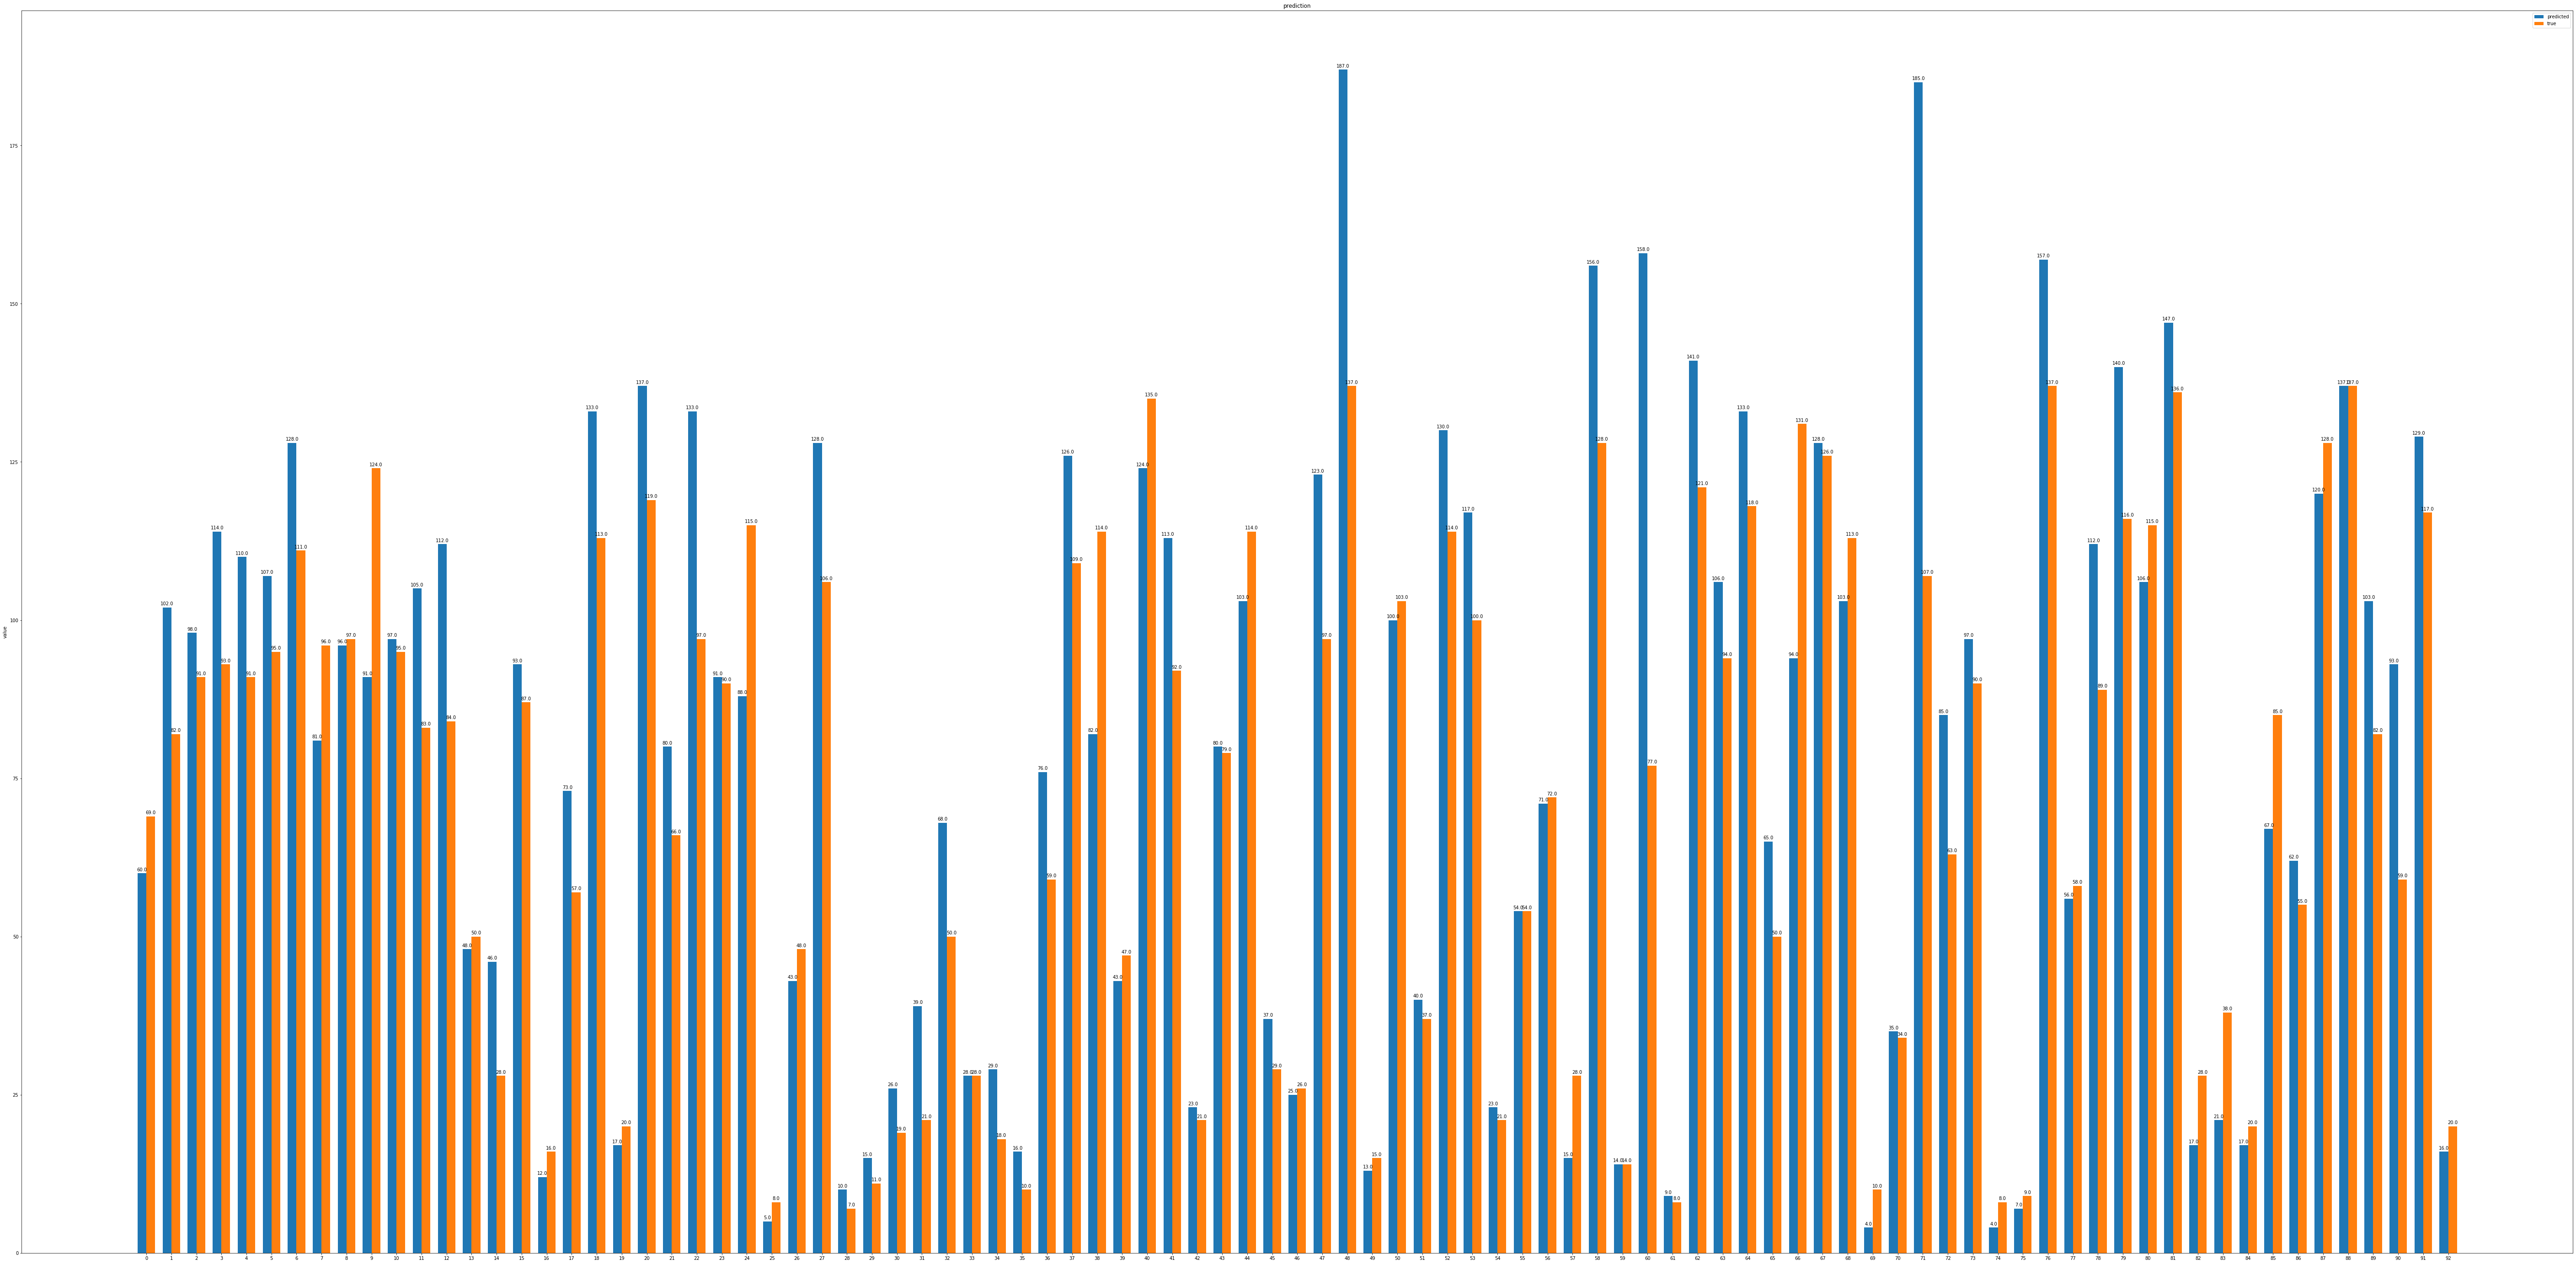

In [0]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
#print(seq_array_test_last)
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):

    # restore weights
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras,'TCN': TCN})

    
    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv(output_path+'/submit_test.csv', index = None)

    # Plot in blue color the predicted data and in orange color the
    # actual data to verify visually the accuracy of the model.
        
    x = np.arange(len(y_pred_test))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(100, 50))
    rects1 = ax.bar(x - width/2, y_pred_test.flatten().round(), width, label='predicted')
    rects2 = ax.bar(x + width/2, y_true_test.flatten(), width, label='true')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('value')
    ax.set_title('prediction')
    ax.set_xticks(x)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    plt.show()
    fig.savefig(output_path+"/model_verify_bar.png")